In [33]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import seaborn as sns
from statsmodels.tsa.api import VAR

In [6]:
# Loading the data
data = pd.read_csv('WPM_Historical_Data.csv', parse_dates=['Date'], index_col='Date')
data = data.sort_index()

C:\Users\USER PC\AppData\Local\Temp\ipykernel_16040\1314372302.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('WPM_Historical_Data.csv', parse_dates=['Date'], index_col='Date')


In [7]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-31,59.13,58.46,59.45,58.12,608.65K,1.55%
2023-08-01,58.20,58.29,58.67,57.83,486.91K,-1.57%
2023-08-02,56.40,58.09,58.09,56.34,989.31K,-3.09%
2023-08-03,56.63,56.27,56.68,55.73,618.68K,0.41%
2023-08-04,58.79,56.99,58.95,56.99,835.55K,3.81%


## Data Cleaning

In [8]:
# removing k from volume column
df = data.copy()
df.head()

df["Vol."] = (
    df["Vol."].apply(
        lambda x: float(x[0:-1]) * 1000 
        if "K" in x 
        else float(x[0:-1]) * 1000_000)
)

# removing percentage sign from change % column
df["Change %"] = df["Change %"].str.strip("%").astype(float)

df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-31,59.13,58.46,59.45,58.12,608650.0,1.55
2023-08-01,58.20,58.29,58.67,57.83,486910.0,-1.57
2023-08-02,56.40,58.09,58.09,56.34,989310.0,-3.09
2023-08-03,56.63,56.27,56.68,55.73,618680.0,0.41
2023-08-04,58.79,56.99,58.95,56.99,835550.0,3.81


In [9]:
# checking data
# shape
df.shape

# info
df.info()

# describe
df.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2023-07-31 to 2025-07-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     503 non-null    float64
 1   Open      503 non-null    float64
 2   High      503 non-null    float64
 3   Low       503 non-null    float64
 4   Vol.      503 non-null    float64
 5   Change %  503 non-null    float64
dtypes: float64(6)
memory usage: 27.5 KB


,Price,Open,High,Low,Vol.,Change %
count,503.000000,503.000000,503.000000,503.000000,5.030000e+02,503.000000
mean,81.984274,81.873400,82.866083,80.916561,7.489948e+05,0.170974
std,21.044933,20.949957,21.270765,20.658746,5.010930e+05,1.874995
min,52.920000,53.080000,53.220000,52.150000,6.498000e+04,-8.780000
25%,63.535000,63.505000,64.180000,62.665000,5.027400e+05,-0.835000
50%,80.500000,80.300000,81.120000,79.440000,6.354600e+05,0.180000
75%,93.165000,93.030000,94.240000,92.240000,8.409600e+05,1.360000
max,130.190000,130.170000,131.820000,128.740000,5.100000e+06,5.810000


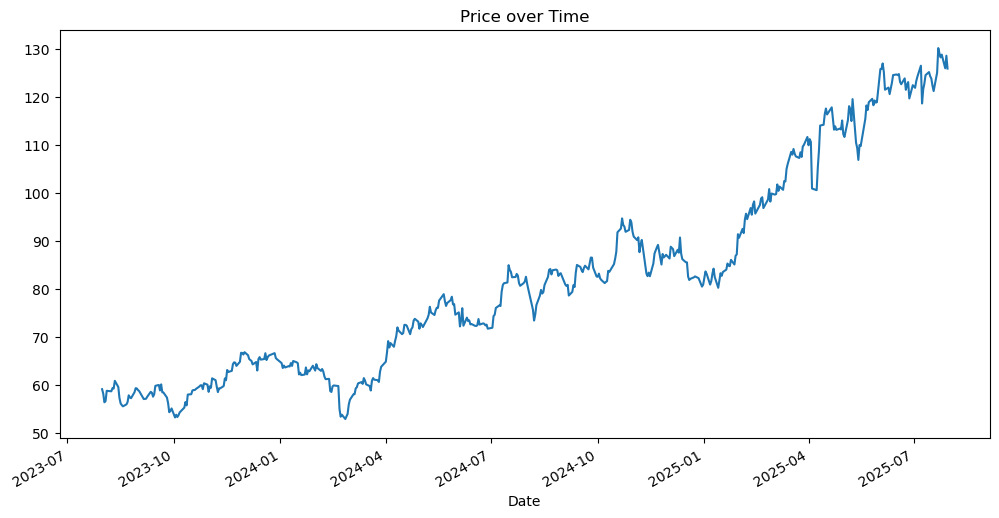

In [10]:
# Lineplot of the price column over time
df_price = df.Price
df_price.plot(figsize=(12, 6), title='Price over Time')
plt.show()

## Building an Arima Model

In [11]:
# Adf fuller test
# Stationarity test
adf_result = adfuller(df_price)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] > 0.05:
    price_diff = df_price.diff().dropna()
    d = 1
else:
    price_diff = df_price 
    d = 0
print(d)    

ADF Statistic: 0.43063529707515497
p-value: 0.9826051408395706
1


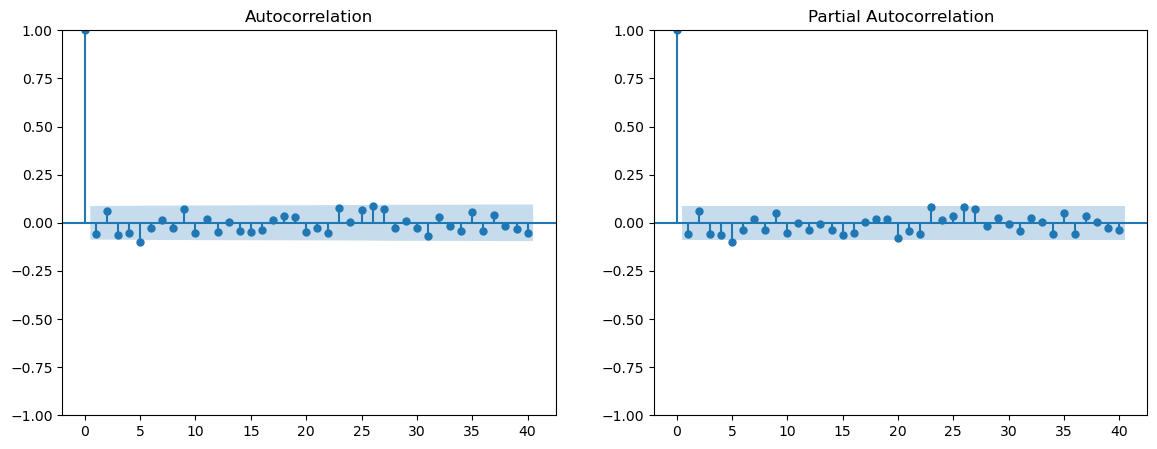

In [12]:
# ACF & PACF for differenced series
fig, axes = plt.subplots(1,2, figsize=(14,5))
plot_acf(price_diff, lags=40, ax=axes[0])
plot_pacf(price_diff, lags=40, ax=axes[1])
plt.show()

In [13]:
# Set p and q manually after checking plots
p, q = 0, 0 

# Train-test split
train_size = int(len(price_diff) * 0.8)
train, test = price_diff[:train_size], price_diff[train_size:]
train.shape, test.shape

((401,), (101,))

In [14]:
# Fit ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  401
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -824.060
Date:                Wed, 03 Sep 2025   AIC                           1650.119
Time:                        11:25:54   BIC                           1654.111
Sample:                             0   HQIC                          1651.700
                                - 401                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.6053      0.224     16.097      0.000       3.166       4.044
Ljung-Box (L1) (Q):                 111.74   Jarque-Bera (JB):                 6.58
Prob(Q):                              0.00   Pr

c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Forecasting the test data using ARIMA model
forecast = model_fit.forecast(steps=len(test))
forecast_df = pd.DataFrame(forecast)
forecast_df.set_index(test.index, inplace=True)

c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
# Evaluating the ARIMA model with the test and forecasted data
mae = mean_absolute_error(test, forecast_df)
rmse = np.sqrt(mean_squared_error(test, forecast_df))
mape = mean_absolute_percentage_error(test, forecast_df)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {100 * mape:.2f}%")

MAE: 2.34
RMSE: 3.03
MAPE: 300.57%


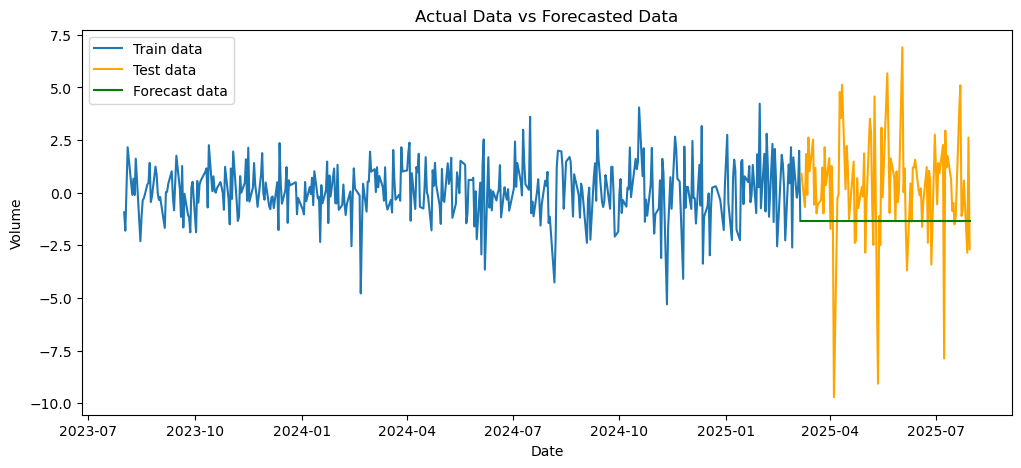

In [17]:
# Plot forecast vs actual
plt.figure(figsize=(12,5))
plt.plot(train, label='Train data')
plt.plot(test, label='Test data', color='orange')
plt.plot(forecast_df, label='Forecast data', color='green')
plt.title('Actual Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

## Arimax Model

In [18]:
# Defining target and exogenous features
y = df['Price']
X = df.drop(columns=['Price'])

In [21]:
# Set p and q manually after checking plots
p, q = 0, 0  

# Train-test split
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

In [22]:
# Fit ARIMAX
model = ARIMA(y_train, order=(p, d, q), exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  402
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1307.648
Date:                Wed, 03 Sep 2025   AIC                           2627.296
Time:                        11:48:50   BIC                           2651.260
Sample:                             0   HQIC                          2636.785
                                - 402                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.0432     14.497     -0.003      0.998     -28.457      28.370
High           0.4025     12.175      0.033      0.974     -23.460      24.265
Low            0.3630     14.214      0.026      0.9

c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# Forecast with exogenous variables
forecast = model_fit.forecast(steps=len(y_test), exog=X_test)
forecast_df = pd.DataFrame(forecast)
forecast_df.set_index(y_test.index, inplace=True)

c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [24]:
mae = mean_absolute_error(y_test, forecast_df)
rmse = np.sqrt(mean_squared_error(y_test, forecast))
mape = mean_absolute_percentage_error(y_test, forecast)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {100 * mape:.2f}%")

MAE: 4.72
RMSE: 5.19
MAPE: 3.94%


C:\Users\USER PC\AppData\Local\Temp\ipykernel_16040\3262079103.py:10: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(y_test.index, forecast, label='Predicted Data', color='red', linestyle='--')


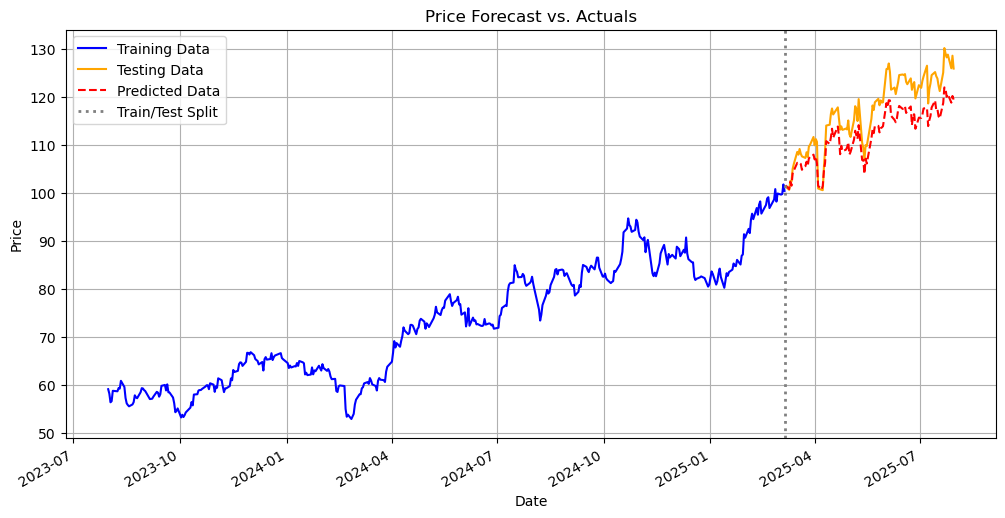

In [25]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot training and testing data
y_train.plot(label='Training Data', color='blue')
y_test.plot(label='Testing Data', color='orange')

# Plot predicted data

plt.plot(y_test.index, forecast, label='Predicted Data', color='red', linestyle='--')

# Add a vertical line at the split point
plt.axvline(df.index[train_size-1], color='gray', linestyle=':', lw=2, label='Train/Test Split')

plt.title('Price Forecast vs. Actuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

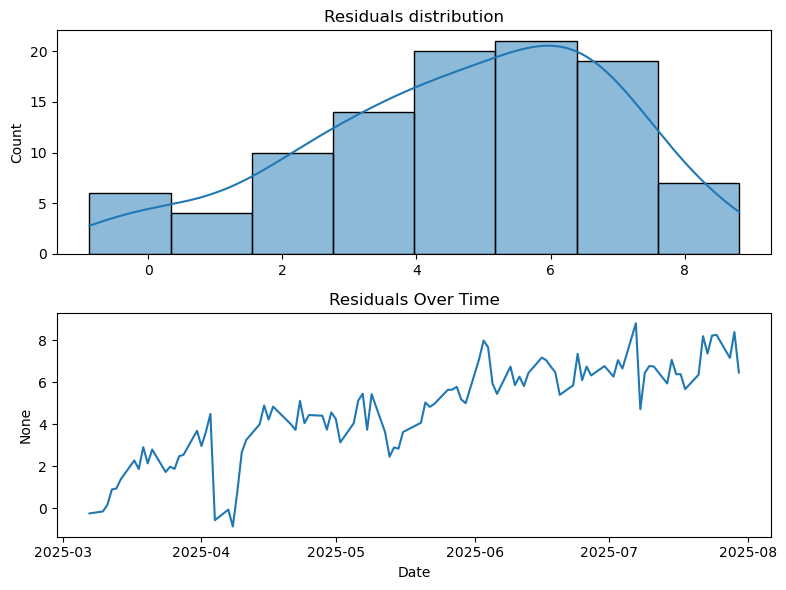

In [27]:
# Calculating and plotting residuals
residuals = y_test - forecast_df["predicted_mean"]
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution")

plt.subplot(2,1,2)
sns.lineplot(x=y_test.index, y=residuals)
plt.title("Residuals Over Time")
plt.tight_layout()
plt.show()

## GRANGER CAUSALITY TEST

In [29]:
# Converting to stationary data
df_diff = df.diff().dropna()
df_diff.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-08-01,-0.93,-0.17,-0.78,-0.29,-121740.0,-3.12
2023-08-02,-1.80,-0.20,-0.58,-1.49,502400.0,-1.52
2023-08-03,0.23,-1.82,-1.41,-0.61,-370630.0,3.50
2023-08-04,2.16,0.72,2.27,1.26,216870.0,3.40
2023-08-08,-0.10,1.01,-0.11,0.84,304450.0,-3.98


In [30]:
# Select the columns for causal analysis
df_causal = df[['Price','Open', 'High', 'Low', 'Vol.', 'Change %']]

# Function to perform Granger Causality test
def granger_causality_test(data, target, predictors, max_lag):
    print(f"Testing for Granger Causality on '{target}' with predictors: {predictors}\n")
    results = {}
    for predictor in predictors:
        if predictor == target:
            continue
        print(f"  Testing if '{predictor}' Granger-causes '{target}'...")
        test_result = grangercausalitytests(data[[target, predictor]], max_lag, verbose=False)
        # The p-value for the F-test is in the third element of the tuple
        p_values = [round(test_result[i][0]['ssr_ftest'][1], 4) for i in range(1, max_lag + 1)]
        results[predictor] = p_values
        print(f"    - p-values for lags 1 to {max_lag}: {p_values}")
    
    print("\nSummary of Granger Causality Test (p-values < 0.05 suggests causality):")
    for predictor, p_values in results.items():
        min_p_value = min(p_values)
        if min_p_value < 0.05:
            print(f"  - Causal relationship found from '{predictor}' to '{target}' (min p-value: {min_p_value})")
        else:
            print(f"  - No significant causal relationship found from '{predictor}' to '{target}' (min p-value: {min_p_value})")
    
    return results

In [31]:
# Performing Granger Causality Test on the preprocessed data and using max lag of 5 as a starting point
causal_results = granger_causality_test(df_causal, target='Price', predictors=df_causal.columns, max_lag=5)

Testing for Granger Causality on 'Price' with predictors: Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

  Testing if 'Open' Granger-causes 'Price'...
    - p-values for lags 1 to 5: [np.float64(0.0018), np.float64(0.0022), np.float64(0.0059), np.float64(0.0257), np.float64(0.0068)]
  Testing if 'High' Granger-causes 'Price'...
    - p-values for lags 1 to 5: [np.float64(0.5579), np.float64(0.9538), np.float64(0.1156), np.float64(0.0829), np.float64(0.0385)]
  Testing if 'Low' Granger-causes 'Price'...
    - p-values for lags 1 to 5: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
  Testing if 'Vol.' Granger-causes 'Price'...
    - p-values for lags 1 to 5: [np.float64(0.1517), np.float64(0.4002), np.float64(0.5864), np.float64(0.7533), np.float64(0.4907)]
  Testing if 'Change %' Granger-causes 'Price'...
    - p-values for lags 1 to 5: [np.float64(0.38), np.float64(0.1813), np.float64(0.4396), np.float64(0.4936), np.f

c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [32]:
# Checking for stationarity using ADF test
def adf_test(series, name=''):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Test for '{name}':")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    if len(result) > 4:
        print(f"  Critical Values: {result[4]}")
    else:
        print("  Critical Values: Not available (result tuple too short)")
    if result[1] <= 0.05:
        print("  - The series is likely stationary.")
        return True
    else:
        print("  - The series is likely non-stationary.")
        return False

# Test all series
stationary = {col: adf_test(df_causal[col], col) for col in df_causal.columns}
print("\nStationarity Summary:")
for col, is_stationary in stationary.items():
    print(f"  - {col}: {'Stationary' if is_stationary else 'Non-Stationary'}")

# If series are non-stationary, difference them
if not all(stationary.values()):
    print("\nDifferencing the non-stationary series...")
    df_diff = df_causal.diff().dropna()
    print("DataFrame after differencing:")
    print(df_diff.head())
    
    # Re-test for stationarity on the differenced data
    print("\nRe-testing stationarity on differenced data:")
    for col in df_diff.columns:
        adf_test(df_diff[col], col)
else:
    df_diff = df_causal

ADF Test for 'Price':
  ADF Statistic: 0.4306
  p-value: 0.9826
  Critical Values: {'1%': np.float64(-3.4435761493506294), '5%': np.float64(-2.867372960189225), '10%': np.float64(-2.5698767442886696)}
  - The series is likely non-stationary.
ADF Test for 'Open':
  ADF Statistic: 0.6865
  p-value: 0.9896
  Critical Values: {'1%': np.float64(-3.4436298692815304), '5%': np.float64(-2.867396599893435), '10%': np.float64(-2.5698893429241916)}
  - The series is likely non-stationary.
ADF Test for 'High':
  ADF Statistic: 0.5319
  p-value: 0.9858
  Critical Values: {'1%': np.float64(-3.4435494520411605), '5%': np.float64(-2.8673612117611267), '10%': np.float64(-2.5698704830567247)}
  - The series is likely non-stationary.
ADF Test for 'Low':
  ADF Statistic: 0.3156
  p-value: 0.9780
  Critical Values: {'1%': np.float64(-3.4435494520411605), '5%': np.float64(-2.8673612117611267), '10%': np.float64(-2.5698704830567247)}
  - The series is likely non-stationary.
ADF Test for 'Vol.':
  ADF Statist

c:\Users\USER PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Optimal Lag Order (based on BIC): 2

VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 03, Sep, 2025
Time:                     12:01:03
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    24.8423
Nobs:                     490.000    HQIC:                   24.4368
Log likelihood:          -10016.4    FPE:                3.15439e+10
AIC:                      24.1746    Det(Omega_mle):     2.69578e+10
--------------------------------------------------------------------
Results for equation Price
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.136098         0.071606            1.901           0.057
L1.Price           -0.312285         0.164801           -1.895           0.058
L1.Open    

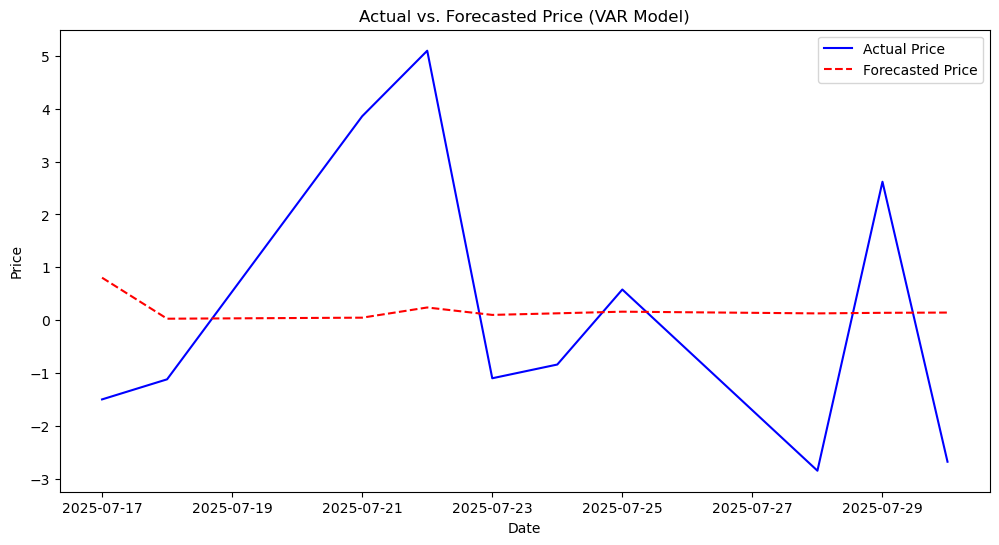


Model Evaluation:
Mean Squared Error (MSE): 7.03
Root Mean Squared Error (RMSE): 2.65

Mean Absolute Percentage Error (MAPE): 1.05%


In [ ]:
nobs = 10
df_train = df_diff[:-nobs]
df_test = df_diff[-nobs:]

# Find the optimal lag order
model = VAR(df_train)
lag_order_results = model.select_order(maxlags=10)
print(f"\nOptimal Lag Order (based on BIC): {lag_order_results.bic}")
optimal_lag = lag_order_results.bic

# Train the VAR model
model_fitted = model.fit(optimal_lag)
print("\nVAR Model Summary:")
print(model_fitted.summary())

# Make predictions on the test set
forecast_input = df_train.values[-optimal_lag:]
forecast = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(forecast, index=df_test.index, columns=df_test.columns)

print("\nForecasted Prices:")
print(df_forecast['Price'])

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df_test['Price'], label='Actual Price', color='blue')
plt.plot(df_forecast['Price'], label='Forecasted Price', color='red', linestyle='--')
plt.title('Actual vs. Forecasted Price (VAR Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluation
mse = mean_squared_error(df_test['Price'], df_forecast['Price'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(df_test['Price'], df_forecast['Price'])

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")